In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# K-modes
import kmodes

# 나무
from sklearn.tree import export_graphviz
import graphviz

# 데이터 분할
from sklearn.model_selection import train_test_split

# 예측 모형: Logistic regression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.model_selection import GridSearchCV

# 평가 함수
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score


# https://pypi.org/project/kmodes/
from kmodes.kmodes import KModes

%matplotlib inline
matplotlib.rc('font', family = 'NanumBarunGothic')

path = '/home/pirl/BDAI-정덕성/Group/Python/'
list_files = ['user.csv', 'address.csv', 'contract.csv']

In [2]:
df = pd.read_csv(path + 'merged_final.csv', engine='python', encoding = 'euc-kr')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49645 entries, 0 to 49644
Data columns (total 23 columns):
gender              49645 non-null object
customerType        49645 non-null object
age                 49645 non-null object
marital             49645 non-null object
residence           49645 non-null object
channel             49645 non-null object
credit              49645 non-null object
payment             49645 non-null object
paymentCO           49645 non-null object
province            49645 non-null object
provinceIS          49645 non-null object
cityGrade           49645 non-null object
channelType         49645 non-null object
contractExtended    49645 non-null object
contractType        49645 non-null object
contractType_1      49645 non-null object
contractType_2      49645 non-null object
cityGradeIS         49645 non-null object
Termination_str     49645 non-null object
maxDay_str          49645 non-null object
maxGift_str         49645 non-null object
Terminati

## X & Y 분리: cityGradeIS 기준

In [4]:
df_tree = df.query('Termination_str == "중도 해약 X"')
df_tree = df_tree.query('customerType == "PERSONAL"')
df_tree['Termination_str'].unique()

array(['중도 해약 X'], dtype=object)

In [5]:
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41529 entries, 0 to 49644
Data columns (total 23 columns):
gender              41529 non-null object
customerType        41529 non-null object
age                 41529 non-null object
marital             41529 non-null object
residence           41529 non-null object
channel             41529 non-null object
credit              41529 non-null object
payment             41529 non-null object
paymentCO           41529 non-null object
province            41529 non-null object
provinceIS          41529 non-null object
cityGrade           41529 non-null object
channelType         41529 non-null object
contractExtended    41529 non-null object
contractType        41529 non-null object
contractType_1      41529 non-null object
contractType_2      41529 non-null object
cityGradeIS         41529 non-null object
Termination_str     41529 non-null object
maxDay_str          41529 non-null object
maxGift_str         41529 non-null object
Terminati

## 품종 3종

In [6]:
df_tree_short = df_tree.drop(['customerType', # 고객/법인 따로 분석
                              'channel', 'channelType',  # channelType 사용
                              'credit', 'payment', 'paymentCO', # 경향성 없음
                              'province', 'provinceIS',
                              'cityGrade', # 실거주지 정보 제외
                              'contractExtended', # 목표변수 파생변수 제외
                              'contractType', 'contractType_2', # 6개 범주 사용
                              'Termination_str', 
                              'maxDay_str', 'maxGift_str', 'Termination_rate', 'overDue_str'],
                             axis=1) # 경향성 없음             
                                  
# X, Y 분리 & Dummy 변수
df_tree_y = df_tree[['contractType_1']]

In [7]:
df_tree_y['contractType_1'].unique()

array(['M', 'E', 'H'], dtype=object)

In [8]:
df_tree_s = pd.get_dummies(df_tree_short.drop('contractType_1', axis=1), drop_first = True)
df_tree_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41529 entries, 0 to 49644
Data columns (total 14 columns):
gender_MALE            41529 non-null uint8
age_30대                41529 non-null uint8
age_40대                41529 non-null uint8
age_50대                41529 non-null uint8
age_60대 이상             41529 non-null uint8
marital_SINGLE         41529 non-null uint8
residence_ETC.         41529 non-null uint8
residence_HOUSE        41529 non-null uint8
residence_OFFICETEL    41529 non-null uint8
cityGradeIS_2급지        41529 non-null uint8
cityGradeIS_3급지        41529 non-null uint8
cityGradeIS_4급지        41529 non-null uint8
cityGradeIS_5급지        41529 non-null uint8
cityGradeIS_6급지        41529 non-null uint8
dtypes: uint8(14)
memory usage: 892.2 KB


In [9]:
# 나무 데이터
df_train_s, df_test_s, df_train_y, df_test_y = train_test_split(df_tree_s, df_tree_y, test_size = 0.3)

print('train data X size:{}'.format(df_train_s.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('test data X size:{}'.format(df_test_s.shape))
print('test data Y size:{}'.format(df_test_y.shape))


train data X size:(29070, 14)
train data Y size:(29070, 1)
test data X size:(12459, 14)
test data Y size:(12459, 1)


# 랜덤포레스트

In [10]:
rf_default = RFC()
rf_default.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
y_train_pred = rf_default.predict(df_train_s)
y_test_pred = rf_default.predict(df_test_s)

# # AUC
# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, y_pred)
# roc_auc_train = auc(false_positive_rate, true_positive_rate)

# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
# roc_auc_test = auc(false_positive_rate, true_positive_rate)

# f1 score
f1_train = f1_score(df_train_y, y_train_pred, average='micro')
f1_test = f1_score(df_test_y, y_test_pred, average='micro')


# print('Accuracy on Training: {0:.3f}\n'.format(rf_default.score(df_train_s, df_train_y)))
# print('Accuracy on Test: {0:.3f}\n'.format(rf_default.score(df_test_s, df_test_y)))

# # print('AUC on Training: {0:.3f}\n'.format(roc_auc_train))
# # print('AUC on Test: {0:.3f}\n'.format(roc_auc_test))
print('F1 on Training: {0:.3f}\n'.format(f1_train))
print('F1 on Test: {0:.3f}\n'.format(f1_test))

F1 on Training: 0.867

F1 on Test: 0.870



### Parameter

In [13]:
params = {'max_depth': None,
          'n_estimators': None,
          'max_leaf_nodes': None,
          'min_samples_leaf': None,
          'min_samples_split': None,
          'max_features': None}

### 숲의 나무 수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was e

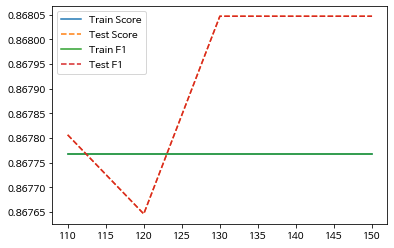

In [18]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# ntree
para_ntree = [10*ntree for ntree in range(11, 16)]


for v_ntree in para_ntree:
    rf = RFC(n_estimators = v_ntree)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_ntree = pd.DataFrame({'N_Tree': para_ntree,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_ntree, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_ntree, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_ntree, train_f1, linestyle='-', label="Train F1")
plt.plot(para_ntree, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [19]:
df_score_ntree.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
2,130,0.867767,0.868047,0.867767,0.868047
3,140,0.867767,0.868047,0.867767,0.868047
4,150,0.867767,0.868047,0.867767,0.868047
0,110,0.867767,0.867806,0.867767,0.867806
1,120,0.867767,0.867646,0.867767,0.867646


In [14]:
params['n_estimators'] = 130

### 나무의 최대 깊이

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


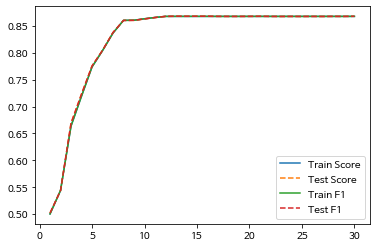

In [22]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# depth
para_depth = [depth for depth in range(1, 31)]


for v_depth in para_depth:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = v_depth)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_depth = pd.DataFrame({'N_Tree': para_depth,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_depth, train_f1, linestyle='-', label="Train F1")
plt.plot(para_depth, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [24]:
df_score_depth.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
15,16,0.867767,0.868047,0.867767,0.868047
12,13,0.867767,0.868047,0.867767,0.868047
14,15,0.867767,0.868047,0.867767,0.868047
20,21,0.867767,0.867967,0.867767,0.867967
13,14,0.867767,0.867967,0.867767,0.867967
29,30,0.867767,0.867967,0.867767,0.867967
19,20,0.867767,0.867806,0.867767,0.867806
11,12,0.867767,0.867806,0.867767,0.867806
27,28,0.867767,0.867806,0.867767,0.867806
16,17,0.867767,0.867806,0.867767,0.867806


In [15]:
params['max_depth'] = 16

### 최소 잎사귀 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys

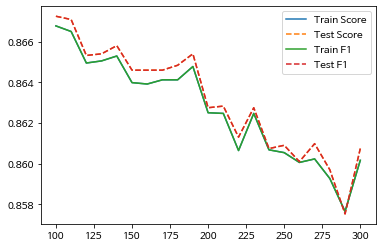

In [31]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# split
para_split = [split*10 for split in range(10, 31)]


for v_split in para_split:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_split = v_split)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_split = pd.DataFrame({'split': para_split,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_split, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_split, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_split, train_f1, linestyle='-', label="Train F1")
plt.plot(para_split, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [33]:
df_score_split.sort_values('TestF1', ascending = False)

,split,TrainScore,TestScore,TrainF1,TestF1
0,100,0.866770,0.867245,0.866770,0.867245
1,110,0.866495,0.867084,0.866495,0.867084
4,140,0.865291,0.865800,0.865291,0.865800
3,130,0.865050,0.865399,0.865050,0.865399
9,190,0.864775,0.865399,0.864775,0.865399
2,120,0.864947,0.865318,0.864947,0.865318
8,180,0.864121,0.864837,0.864121,0.864837
5,150,0.863983,0.864596,0.863983,0.864596
6,160,0.863915,0.864596,0.863915,0.864596
7,170,0.864121,0.864596,0.864121,0.864596


In [16]:
params['min_samples_split'] = 100

### 최소 분리노드 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pi

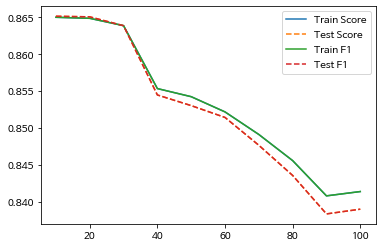

In [36]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# leaf
para_leaf = [leaf*10 for leaf in range(1, 11)]


for v_leaf in para_leaf:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_split = params['min_samples_split'],
             min_samples_leaf = v_leaf)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_leaf = pd.DataFrame({'leaf': para_leaf,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_leaf, train_f1, linestyle='-', label="Train F1")
plt.plot(para_leaf, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [38]:
df_score_leaf.sort_values('TestF1', ascending = False)

,leaf,TrainScore,TestScore,TrainF1,TestF1
0,10,0.865015,0.865158,0.865015,0.865158
1,20,0.864878,0.865077,0.864878,0.865077
2,30,0.863880,0.863874,0.863880,0.863874
3,40,0.855349,0.854483,0.855349,0.854483
4,50,0.854248,0.853038,0.854248,0.853038
5,60,0.852184,0.851433,0.852184,0.851433
6,70,0.849123,0.847660,0.849123,0.847660
7,80,0.845580,0.843567,0.845580,0.843567
9,100,0.841383,0.838992,0.841383,0.838992
8,90,0.840798,0.838350,0.840798,0.838350


In [17]:
params['min_samples_leaf'] = 10

### 최대 사용 변수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

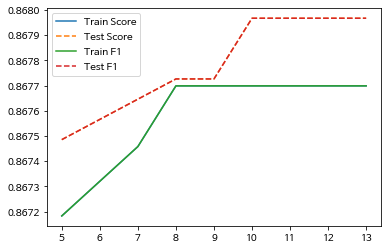

In [41]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# feature
para_feature = [feature for feature in range(5, len(df_train_s.columns))]


for v_feature in para_feature:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = v_feature)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_feature = pd.DataFrame({'feature': para_feature,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_feature, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_feature, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_feature, train_f1, linestyle='-', label="Train F1")
plt.plot(para_feature, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [42]:
df_score_feature.sort_values('TestF1', ascending = False)

,feature,TrainScore,TestScore,TrainF1,TestF1
5,10,0.867699,0.867967,0.867699,0.867967
6,11,0.867699,0.867967,0.867699,0.867967
7,12,0.867699,0.867967,0.867699,0.867967
8,13,0.867699,0.867967,0.867699,0.867967
3,8,0.867699,0.867726,0.867699,0.867726
4,9,0.867699,0.867726,0.867699,0.867726
2,7,0.867458,0.867646,0.867458,0.867646
1,6,0.867320,0.867566,0.867320,0.867566
0,5,0.867183,0.867485,0.867183,0.867485


In [18]:
params['max_features'] = 10

### 최종 모형

In [19]:
rf_final = RFC(n_estimators = params['n_estimators'],
               max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = params['max_features'])
rf_final.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=130,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
y_pred = rf_final.predict(df_test_s)

# f1 score
f1Score = f1_score(df_test_y, y_pred, average = 'micro')

print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

F1: 0.871

Accuracy: 0.871

Confusion Mat:
[[2947   61  575]
 [  48 1951  581]
 [ 216  128 5952]]


In [21]:
df_importance = pd.DataFrame()
v_feature_name = df_train_s.columns
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_ # TREECLASS.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
9,cityGradeIS_2급지,0.156
5,marital_SINGLE,0.121
0,gender_MALE,0.104
2,age_40대,0.095
11,cityGradeIS_4급지,0.088
10,cityGradeIS_3급지,0.085
3,age_50대,0.080
1,age_30대,0.069
12,cityGradeIS_5급지,0.066
4,age_60대 이상,0.050


Text(0, 0.5, '변수')

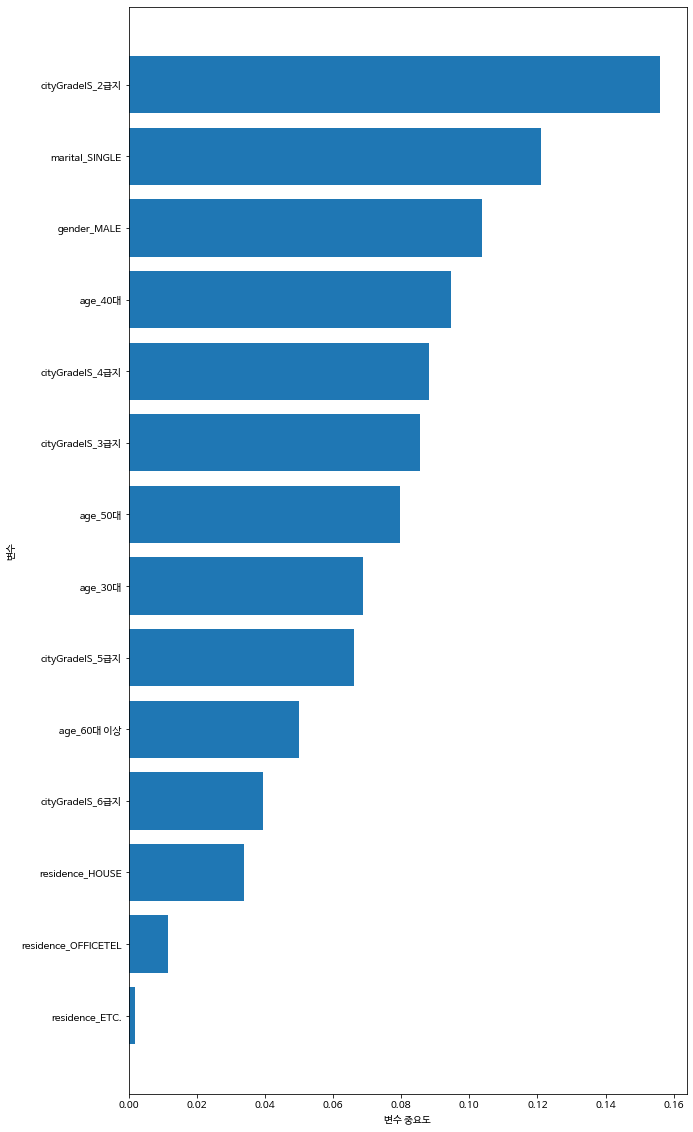

In [22]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# 전체 데이터에 예측

In [23]:
v_feature_name

Index(['gender_MALE', 'age_30대', 'age_40대', 'age_50대', 'age_60대 이상',
       'marital_SINGLE', 'residence_ETC.', 'residence_HOUSE',
       'residence_OFFICETEL', 'cityGradeIS_2급지', 'cityGradeIS_3급지',
       'cityGradeIS_4급지', 'cityGradeIS_5급지', 'cityGradeIS_6급지'],
      dtype='object')

In [24]:
df_customer = df.query('customerType == "PERSONAL"')

df_total_x = pd.get_dummies(df_customer[['gender', 'age', 'marital', 'residence', 'cityGradeIS']],
                            drop_first = True)
df_total_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42334 entries, 0 to 49644
Data columns (total 14 columns):
gender_MALE            42334 non-null uint8
age_30대                42334 non-null uint8
age_40대                42334 non-null uint8
age_50대                42334 non-null uint8
age_60대 이상             42334 non-null uint8
marital_SINGLE         42334 non-null uint8
residence_ETC.         42334 non-null uint8
residence_HOUSE        42334 non-null uint8
residence_OFFICETEL    42334 non-null uint8
cityGradeIS_2급지        42334 non-null uint8
cityGradeIS_3급지        42334 non-null uint8
cityGradeIS_4급지        42334 non-null uint8
cityGradeIS_5급지        42334 non-null uint8
cityGradeIS_6급지        42334 non-null uint8
dtypes: uint8(14)
memory usage: 909.5 KB


In [25]:
y_pred = rf_final.predict(df_total_x)
y_pred = pd.DataFrame(y_pred, index = df_total_x.index, columns = ['predType_1'])

In [26]:
df_total_pred = df_customer
df_total_pred = df_total_pred.merge(y_pred, how = 'inner', left_index = True, right_index = True)

In [27]:
df_total_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42334 entries, 0 to 49644
Data columns (total 24 columns):
gender              42334 non-null object
customerType        42334 non-null object
age                 42334 non-null object
marital             42334 non-null object
residence           42334 non-null object
channel             42334 non-null object
credit              42334 non-null object
payment             42334 non-null object
paymentCO           42334 non-null object
province            42334 non-null object
provinceIS          42334 non-null object
cityGrade           42334 non-null object
channelType         42334 non-null object
contractExtended    42334 non-null object
contractType        42334 non-null object
contractType_1      42334 non-null object
contractType_2      42334 non-null object
cityGradeIS         42334 non-null object
Termination_str     42334 non-null object
maxDay_str          42334 non-null object
maxGift_str         42334 non-null object
Terminati

In [28]:
df_total_pred.to_csv('pred_type1.csv', encoding = 'euc-kr')

### 렌탈기간 예측

In [29]:
df_pred_type2 = pd.read_csv('pred_type2.csv', encoding = 'euc-kr', engine = 'python')
df_pred_type2.index = df_total_x.index
df_pred_type2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42334 entries, 0 to 49644
Data columns (total 25 columns):
Unnamed: 0          42334 non-null int64
gender              42334 non-null object
customerType        42334 non-null object
age                 42334 non-null object
marital             42334 non-null object
residence           42334 non-null object
channel             42334 non-null object
credit              42334 non-null object
payment             42334 non-null object
paymentCO           42334 non-null object
province            42334 non-null object
provinceIS          42334 non-null object
cityGrade           42334 non-null object
channelType         42334 non-null object
contractExtended    42334 non-null object
contractType        42334 non-null object
contractType_1      42334 non-null object
contractType_2      42334 non-null object
cityGradeIS         42334 non-null object
Termination_str     42334 non-null object
maxDay_str          42334 non-null object
maxGift_st

In [30]:
df_total_pred = df_total_pred.merge(df_pred_type2['predType_2'],
                                    how = 'inner', left_index = True, right_index = True)

### 6종 예측

In [31]:
df_pred_type3 = pd.read_csv('pred_type3.csv', encoding = 'euc-kr', engine = 'python')
df_pred_type3.index = df_total_x.index
df_pred_type3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42334 entries, 0 to 49644
Data columns (total 25 columns):
Unnamed: 0          42334 non-null int64
gender              42334 non-null object
customerType        42334 non-null object
age                 42334 non-null object
marital             42334 non-null object
residence           42334 non-null object
channel             42334 non-null object
credit              42334 non-null object
payment             42334 non-null object
paymentCO           42334 non-null object
province            42334 non-null object
provinceIS          42334 non-null object
cityGrade           42334 non-null object
channelType         42334 non-null object
contractExtended    42334 non-null object
contractType        42334 non-null object
contractType_1      42334 non-null object
contractType_2      42334 non-null object
cityGradeIS         42334 non-null object
Termination_str     42334 non-null object
maxDay_str          42334 non-null object
maxGift_st

In [32]:
df_total_pred = df_total_pred.merge(df_pred_type3['predType_3'],
                    how = 'inner', left_index = True, right_index = True)

In [33]:
df_total_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42334 entries, 0 to 49644
Data columns (total 26 columns):
gender              42334 non-null object
customerType        42334 non-null object
age                 42334 non-null object
marital             42334 non-null object
residence           42334 non-null object
channel             42334 non-null object
credit              42334 non-null object
payment             42334 non-null object
paymentCO           42334 non-null object
province            42334 non-null object
provinceIS          42334 non-null object
cityGrade           42334 non-null object
channelType         42334 non-null object
contractExtended    42334 non-null object
contractType        42334 non-null object
contractType_1      42334 non-null object
contractType_2      42334 non-null object
cityGradeIS         42334 non-null object
Termination_str     42334 non-null object
maxDay_str          42334 non-null object
maxGift_str         42334 non-null object
Terminati

In [34]:
conditions = [(df_total_pred['contractType_1'] == df_total_pred['predType_1'])]
choices = [1]
df_total_pred['match_1'] = np.select(conditions, choices, default=0)
df_total_pred.head()

,gender,customerType,age,marital,residence,channel,credit,payment,paymentCO,province,...,cityGradeIS,Termination_str,maxDay_str,maxGift_str,Termination_rate,overDue_str,predType_1,predType_2,predType_3,match_1
0,FEMALE,PERSONAL,50대,SINGLE,OFFICETEL,서비스 방문,MIDDLE,CARD,현대카드,경기도,...,2급지,중도 해약 X,목요일,지급 X,A,0일,M,M,MMQ,1
1,FEMALE,PERSONAL,20대,MARRIED,OFFICETEL,렌탈재계약,MIDDLE,CMS,국민은행,서울시,...,1급지,중도 해약 X,토요일,지급 O,A,0일,E,I,EIQ,1
2,FEMALE,PERSONAL,30대,MARRIED,OFFICETEL,렌탈총판,HIGH,CMS,기업은행,충청도,...,1급지,중도 해약 X,화요일,지급 O,B,0일,H,I,HIQ,1
3,MALE,PERSONAL,20대,MARRIED,ETC.,하이마트,MIDDLE,CMS,국민은행,서울시,...,1급지,중도 해약 X,토요일,지급 O,B,0일,M,I,MIQ,1
4,MALE,PERSONAL,30대,SINGLE,ETC.,하이마트,MIDDLE,CMS,기업은행,서울시,...,2급지,중도 해약 X,목요일,지급 O,B,0일,M,I,MIQ,1


In [35]:
conditions = [(df_total_pred['contractType_2'] == df_total_pred['predType_2'])]
choices = [1]
df_total_pred['match_2'] = np.select(conditions, choices, default=0)
df_total_pred.head()

,gender,customerType,age,marital,residence,channel,credit,payment,paymentCO,province,...,Termination_str,maxDay_str,maxGift_str,Termination_rate,overDue_str,predType_1,predType_2,predType_3,match_1,match_2
0,FEMALE,PERSONAL,50대,SINGLE,OFFICETEL,서비스 방문,MIDDLE,CARD,현대카드,경기도,...,중도 해약 X,목요일,지급 X,A,0일,M,M,MMQ,1,1
1,FEMALE,PERSONAL,20대,MARRIED,OFFICETEL,렌탈재계약,MIDDLE,CMS,국민은행,서울시,...,중도 해약 X,토요일,지급 O,A,0일,E,I,EIQ,1,1
2,FEMALE,PERSONAL,30대,MARRIED,OFFICETEL,렌탈총판,HIGH,CMS,기업은행,충청도,...,중도 해약 X,화요일,지급 O,B,0일,H,I,HIQ,1,1
3,MALE,PERSONAL,20대,MARRIED,ETC.,하이마트,MIDDLE,CMS,국민은행,서울시,...,중도 해약 X,토요일,지급 O,B,0일,M,I,MIQ,1,1
4,MALE,PERSONAL,30대,SINGLE,ETC.,하이마트,MIDDLE,CMS,기업은행,서울시,...,중도 해약 X,목요일,지급 O,B,0일,M,I,MIQ,1,0


In [36]:
conditions = [(df_total_pred['contractType'] == df_total_pred['predType_3'])]
choices = [1]
df_total_pred['match_3'] = np.select(conditions, choices, default=0)
df_total_pred.head()

,gender,customerType,age,marital,residence,channel,credit,payment,paymentCO,province,...,maxDay_str,maxGift_str,Termination_rate,overDue_str,predType_1,predType_2,predType_3,match_1,match_2,match_3
0,FEMALE,PERSONAL,50대,SINGLE,OFFICETEL,서비스 방문,MIDDLE,CARD,현대카드,경기도,...,목요일,지급 X,A,0일,M,M,MMQ,1,1,1
1,FEMALE,PERSONAL,20대,MARRIED,OFFICETEL,렌탈재계약,MIDDLE,CMS,국민은행,서울시,...,토요일,지급 O,A,0일,E,I,EIQ,1,1,1
2,FEMALE,PERSONAL,30대,MARRIED,OFFICETEL,렌탈총판,HIGH,CMS,기업은행,충청도,...,화요일,지급 O,B,0일,H,I,HIQ,1,1,1
3,MALE,PERSONAL,20대,MARRIED,ETC.,하이마트,MIDDLE,CMS,국민은행,서울시,...,토요일,지급 O,B,0일,M,I,MIQ,1,1,1
4,MALE,PERSONAL,30대,SINGLE,ETC.,하이마트,MIDDLE,CMS,기업은행,서울시,...,목요일,지급 O,B,0일,M,I,MIQ,1,0,0


In [37]:
conditions = [(df_total_pred['match_1'] + df_total_pred['match_2'] == 2)]
choices = [1]
df_total_pred['match_sep'] = np.select(conditions, choices, default=0)
df_total_pred.head()

,gender,customerType,age,marital,residence,channel,credit,payment,paymentCO,province,...,maxGift_str,Termination_rate,overDue_str,predType_1,predType_2,predType_3,match_1,match_2,match_3,match_sep
0,FEMALE,PERSONAL,50대,SINGLE,OFFICETEL,서비스 방문,MIDDLE,CARD,현대카드,경기도,...,지급 X,A,0일,M,M,MMQ,1,1,1,1
1,FEMALE,PERSONAL,20대,MARRIED,OFFICETEL,렌탈재계약,MIDDLE,CMS,국민은행,서울시,...,지급 O,A,0일,E,I,EIQ,1,1,1,1
2,FEMALE,PERSONAL,30대,MARRIED,OFFICETEL,렌탈총판,HIGH,CMS,기업은행,충청도,...,지급 O,B,0일,H,I,HIQ,1,1,1,1
3,MALE,PERSONAL,20대,MARRIED,ETC.,하이마트,MIDDLE,CMS,국민은행,서울시,...,지급 O,B,0일,M,I,MIQ,1,1,1,1
4,MALE,PERSONAL,30대,SINGLE,ETC.,하이마트,MIDDLE,CMS,기업은행,서울시,...,지급 O,B,0일,M,I,MIQ,1,0,0,0


In [39]:
df_total_pred[['contractType', 'predType_1', 'predType_2', 'predType_3', 'match_1', 'match_2', 'match_3', 'match_sep']].head(30)

,contractType,predType_1,predType_2,predType_3,match_1,match_2,match_3,match_sep
0,MMQ,M,M,MMQ,1,1,1,1
1,EIQ,E,I,EIQ,1,1,1,1
2,HIQ,H,I,HIQ,1,1,1,1
3,MIQ,M,I,MIQ,1,1,1,1
4,MMQ,M,I,MIQ,1,0,0,0
5,HMQ,H,M,HMQ,1,1,1,1
6,MIQ,M,I,MIQ,1,1,1,1
7,MIQ,M,I,MIQ,1,1,1,1
9,MIQ,M,I,MIQ,1,1,1,1
10,MIQ,M,I,MIQ,1,1,1,1


In [40]:
df_total_pred[['contractType', 'predType_1', 'predType_2', 'predType_3', 'match_1', 'match_2', 'match_3', 'match_sep']].describe()

,match_1,match_2,match_3,match_sep
count,42334.000000,42334.000000,42334.000000,42334.000000
mean,0.859073,0.709005,0.611140,0.610030
std,0.347950,0.454227,0.487497,0.487749
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


## Match 여부에 따른 중도이탈률

In [41]:
df_crosstab = pd.concat([pd.crosstab(df_total_pred.Termination_str, df_total_pred.match_sep, margins=True),
                         pd.crosstab(df_total_pred.Termination_str, df_total_pred.match_sep).apply(lambda r: r/r.sum(), axis=0),                   
                         pd.crosstab(df_total_pred.Termination_str, df_total_pred.match_sep).apply(lambda r: r/r.sum(), axis=1)])
df_crosstab.round(3)

match_sep,0,1,All
Termination_str,,,
중도 해약 O,561.000,244.000,805.0
중도 해약 X,15948.000,25581.000,41529.0
All,16509.000,25825.000,42334.0
중도 해약 O,0.034,0.009,NaN
중도 해약 X,0.966,0.991,NaN
중도 해약 O,0.697,0.303,NaN
중도 해약 X,0.384,0.616,NaN


In [42]:
df_crosstab = pd.concat([pd.crosstab(df_total_pred.Termination_str, df_total_pred.match_3, margins=True),
                         pd.crosstab(df_total_pred.Termination_str, df_total_pred.match_3).apply(lambda r: r/r.sum(), axis=0),                   
                         pd.crosstab(df_total_pred.Termination_str, df_total_pred.match_3).apply(lambda r: r/r.sum(), axis=1)])
df_crosstab.round(3)

match_3,0,1,All
Termination_str,,,
중도 해약 O,562.000,243.000,805.0
중도 해약 X,15900.000,25629.000,41529.0
All,16462.000,25872.000,42334.0
중도 해약 O,0.034,0.009,NaN
중도 해약 X,0.966,0.991,NaN
중도 해약 O,0.698,0.302,NaN
중도 해약 X,0.383,0.617,NaN
